In [1]:
take = 3
AGENT = "TestEnv"

# Specification

In [2]:
control_rate = 125 #Hz
force_scale = 1
dt = 0.1
model_number = 999
max_limit = 0.00005 #0.0001 0.000085
R1 = 1
R2 = 0.00025
R_success = 250
reality_distance_threshold = 0.0075

reality_horizon = 3000

# Imports

In [3]:
# General imports
import os
import time
import datetime
from os.path import expanduser
import pandas
import pickle
import json
import numpy
from matplotlib import pyplot as plt


# Gym imports
from gym.envs.robotics.ur10 import randomize
from gym.envs.robotics.ur10 import pos_randomize
#from gym.envs.robotics import ur10_noisy_pd_env_mh
from gym.envs.robotics import ur10_sim2real_env
from gym.envs.robotics import ur10_sim2real_pos_env
from gym import utils
from gym.envs.robotics import rotations, utils
#from gym.envs.robotics import ur10_force_env_3
#from gym.envs.robotics import ur10_force_env

# MuJoCo imports
import mujoco_py

# ROS imports
import rospy
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
from std_msgs.msg import String
from geometry_msgs.msg import WrenchStamped
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint
from realsense2_camera.msg import CustomVector
from realsense2_camera.msg import EstimatedPose

In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

# Paths

In [4]:
HOME_PATH = os.getenv("HOME")
PROJECT_PATH = os.path.join(*[HOME_PATH, "DRL_AI4RoMoCo"])
SAVE_PATH = os.path.join(*[PROJECT_PATH, "code", "data","TEST_Reality"])

XML_MODEL_PATH = os.path.join(*[HOME_PATH, "DRL_AI4RoMoCo", "code", "environment","UR10_single","ur10_heg.xml"])   #Force
#XML_MODEL_PATH = os.path.join(*[HOME_PATH, "DRL_AI4RoMoCo", "code", "environment","UR10_single_position","ur10_heg_position.xml"])

env_config = "real_config_force.yml"
#checkpoint_number = 4950
#model = "PPO_NoisyPositionEnv_0_2020-09-18_20-14-55ej_cw9mo"
control_type = env_config.split("_")[2].split(".")[0]

if control_type == "force":
    XML_MODEL_PATH = os.path.join(*[HOME_PATH, "DRL_AI4RoMoCo", "code", "environment","UR10_single","ur10_heg.xml"])   #Force
    print("Force Control")
elif control_type == "position":
    XML_MODEL_PATH = os.path.join(*[HOME_PATH, "DRL_AI4RoMoCo", "code", "environment","UR10_single_position","ur10_heg_position.xml"])
    print("Position Control")
else:
    print("ERROR")

ENV_CONFIG = os.path.join(*[HOME_PATH, "AGENT_TESTS", env_config])
#ENV_CONFIG = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_ForceEnv_0_2020-09-10_15-29-51_j1bhegb", config])

Force Control


# Configuration

Hardware - Environment (ROS)

In [5]:
actual_q = numpy.zeros(6,)
ft_values = numpy.zeros(6,)

Simulation - Environment (MuJoCo, Gym)

In [6]:
#goal = numpy.array([0.69423743, -0.83110109,  1.17388998, -1.57161506,  0.02185773, -3.14102438])
goal = numpy.array([0.69539974, -0.83325208,  1.17396257, -1.57092218,  0.02244061, 3.14048138])
reward_type = "dense"
distance_threshold = 0.002
fail_threshold = 0.25
punish_force = False
punish_force_thresh = 20
punish_force_factor = 0.001
print(goal)

[ 0.69539974 -0.83325208  1.17396257 -1.57092218  0.02244061  3.14048138]


In [7]:
initial_qpos_simpheg_conf2 = numpy.array([0, -1.3, 2.1, -0.80, 1.5708, 0])

# Functions

In [8]:
def normalize_rad(angles):
    angles = numpy.array(angles)
    angles = angles % (2*numpy.pi)
    angles = (angles + 2*numpy.pi) % (2*numpy.pi)
    for i in range(len(angles)):
        if (angles[i] > numpy.pi):
            angles[i] -= 2*numpy.pi
    return angles

def get_obs():
    set_state(actual_q)
    for i in range(10):
        viewer.render()
    #print(ft_values)
    x_pos = sim.data.get_body_xpos("gripper_dummy_heg")
    x_mat = sim.data.get_body_xmat("gripper_dummy_heg")
    rpy =  normalize_rad(rotations.mat2euler(x_mat))
    #print(x_pos, rpy)

    obs = numpy.concatenate([
                x_mat.dot(x_pos-goal[:3]), x_mat.dot(normalize_rad(rpy-goal[3:])), ft_values.copy()
            ])
    return obs

def get_dq(dx):
    jacp = sim.data.get_body_jacp(name="gripper_dummy_heg").reshape(3, 6)
    jacr = sim.data.get_body_jacr(name="gripper_dummy_heg").reshape(3, 6)
    jac = numpy.vstack((jacp, jacr))
    dq = numpy.linalg.lstsq(jac, dx)[0].reshape(6, )
    return dq

def go_smooth(q):
    rate = rospy.Rate(125)
    dq = q - actual_q
    while numpy.linalg.norm(dq)>0.005:
        dq = q - actual_q
        dq_ = numpy.clip(dq, -0.0001, 0.0001)
        control(ctrl_q+dq_)
        rate.sleep()
    control(q)
    
def set_state(qpos):
    #assert qpos.shape == (model.nq,)
    old_state = sim.get_state()
    new_state = mujoco_py.MjSimState(old_state.time, qpos, old_state.qvel,
                                     old_state.act, old_state.udd_state)
    sim.set_state(new_state)
    sim.forward()
    
def keep_going(steps, num_steps, episodes, num_episodes):
    """Determine whether we've collected enough data"""
    # if num_episodes is set, this overrides num_steps
    if num_episodes:
        return episodes < num_episodes
    # if num_steps is set, continue until we reach the limit
    if num_steps:
        return steps < num_steps
    # otherwise keep going forever
    return True

# Observations

In [9]:
def q_callback(data):
    '''Callback for the joint angles, velocities and accelerations'''
    global actual_q
    actual_q = numpy.array(data.position)[[2,1,0,3,4,5]]
    set_state(actual_q)
    viewer.render()

def pose_callback(data):
    '''ROS Callback function for the pose_estimation'''
    global pose
    pose = numpy.array([(-1)*data.tx, data.ty, data.tz]) #, data.rx, data.ry, data.rz])
        
def ft_callback(data):
    '''ROS Callback function for the force-torque data'''
    global ft_values
    ft_values = (-1)* numpy.array([data.wrench.force.x, data.wrench.force.y, data.wrench.force.z, data.wrench.torque.x, data.wrench.torque.y, data.wrench.torque.z])  

def get_real_obs():
    
    set_state(actual_q)
    
    real_pos = pose.copy()
    
    x_mat = sim.data.get_body_xmat("gripper_dummy_heg")
    rpy =  normalize_rad(rotations.mat2euler(x_mat))

    obs = numpy.concatenate([
                x_mat.dot(real_pos), x_mat.dot(normalize_rad(rpy-goal[3:])), force_scale*ft_values.copy()
            ])
    return obs

ROS

In [10]:
def goal_distance(obs, goal):
    '''Compute distance between TCP and Goal'''
    obs = obs[:6]
    assert obs.shape == goal.shape
    return numpy.linalg.norm(obs*numpy.array([1, 1, 1, 0.3, 0.3, 0.3]), axis=-1)

def compute_reward(obs, goal):
    d = goal_distance(obs,goal)
    f = numpy.absolute(obs[7]) + numpy.absolute(obs[8]) + numpy.absolute(obs[9])
    rew = R1 * (-d) + R2 *(-f)
    return rew

def is_success(obs):
    distance = numpy.absolute(obs[0]) + numpy.absolute(obs[1]) + numpy.absolute(obs[2])
    if distance < reality_distance_threshold:
        return True
    else:
        return False

In [11]:
# ROS control commands
def control(q):
    '''Controlling the Universal Robot UR10 JointGroupPositionController'''
    global ctrl_q
    command = Float64MultiArray()
    command.data = q
    control_publisher.publish(command)
    ctrl_q = q.copy()
    
def traj_control(q):
    #dt = 0.025
    global ctrl_q
    command = JointTrajectory()
    point = JointTrajectoryPoint()
    
    #command.header.stamp = rospy.Time.now()
    #command.header.frame_id = "DRL_UR10"
    #command.joint_names = ["elbow_joint", "shoulder_lift_joint", "shoulder_pan_joint", "wrist_1_joint", "wrist_2_joint", "wrist_3_joint"]
    
    #command.header.stamp = rospy.Time.now()
    command.header.frame_id = "DRL_UR10"
    command.joint_names.append("shoulder_pan_joint")
    command.joint_names.append("shoulder_lift_joint")
    command.joint_names.append("elbow_joint")
    command.joint_names.append("wrist_1_joint")
    command.joint_names.append("wrist_2_joint")
    command.joint_names.append("wrist_3_joint")
    

    point.positions.append(q[0])
    point.positions.append(q[1])
    point.positions.append(q[2])
    point.positions.append(q[3])
    point.positions.append(q[4])
    point.positions.append(q[5])
    
    command.points.append(point)
    command.points[0].time_from_start=rospy.Duration.from_sec(dt)
    
    traj_control_publisher.publish(command)
    ctrl_q = q.copy()
    
def static_approach():
    
    waypoint0 = numpy.array([1.6256170272827148, -0.9155753294574183, 1.5307668447494507, -0.6977546850787562, 1.5475375652313232, 0.011224725283682346])[[2,1,0,3,4,5]]
    waypoint1 = numpy.array([2.47381329536438, -1.4324410597430628, 1.5743204355239868, -1.0292657057391565, 1.5910834074020386, 0.011859889142215252])[[2,1,0,3,4,5]]
    waypoint2 = numpy.array([2.519468069076538, -1.6841238180743616, 0.13313426077365875, -0.8226664702044886, 1.7688652276992798, 0.014099815860390663])[[2,1,0,3,4,5]]
    waypoint3 = numpy.array([2.1001405715942383, -1.3000262419330042, 7.190534961409867e-05, -0.7999804655658167, 1.5709056854248047, -3.5587941304981996e-05])[[2,1,0,3,4,5]]
    
    dt_static = 2
    command = JointTrajectory()
    point0 = JointTrajectoryPoint()
    point1 = JointTrajectoryPoint()
    point2 = JointTrajectoryPoint()
    point3 = JointTrajectoryPoint()
    
    command.header.stamp = rospy.Time.now()
    command.header.frame_id = "DRL_UR10"
    command.joint_names.append("shoulder_pan_joint")
    command.joint_names.append("shoulder_lift_joint")
    command.joint_names.append("elbow_joint")
    command.joint_names.append("wrist_1_joint")
    command.joint_names.append("wrist_2_joint")
    command.joint_names.append("wrist_3_joint")
    
    point0.positions.append(waypoint0[0])
    point0.positions.append(waypoint0[1])
    point0.positions.append(waypoint0[2])
    point0.positions.append(waypoint0[3])
    point0.positions.append(waypoint0[4])
    point0.positions.append(waypoint0[5])
    
    #command.points.append(point0)
    
    point1.positions.append(waypoint1[0])
    point1.positions.append(waypoint1[1])
    point1.positions.append(waypoint1[2])
    point1.positions.append(waypoint1[3])
    point1.positions.append(waypoint1[4])
    point1.positions.append(waypoint1[5])
    
    command.points.append(point1)
    command.points[0].time_from_start=rospy.Duration.from_sec(dt_static)
    
    point2.positions.append(waypoint2[0])
    point2.positions.append(waypoint2[1])
    point2.positions.append(waypoint2[2])
    point2.positions.append(waypoint2[3])
    point2.positions.append(waypoint2[4])
    point2.positions.append(waypoint2[5])
    
    command.points.append(point2)
    command.points[1].time_from_start=rospy.Duration.from_sec(2*dt_static)
    
    point3.positions.append(waypoint3[0])
    point3.positions.append(waypoint3[1])
    point3.positions.append(waypoint3[2])
    point3.positions.append(waypoint3[3])
    point3.positions.append(waypoint3[4])
    point3.positions.append(waypoint3[5])
    
    command.points.append(point3)
    command.points[2].time_from_start=rospy.Duration.from_sec(2.5*dt_static)
    
    traj_control_publisher.publish(command)
    
def ft_zero():
    '''Zeroes the Robotiq FT300 force torque sensor by sending an ur_script via UR Secondary Interface'''
    zero_sensor_urscript = 'sec ft_set_zero():' + '\n' + '\t' + 'if(socket_open("127.0.0.1", 63350, "acc")):' \
          + '\n' + '\t' + '\t' + 'socket_send_string("SET ZRO", "acc")' \
         + '\n' + '\t' + '\t' + 'socket_close("acc")' + '\n' + '\t' + 'end' + '\n' + 'end' + '\n'
    ft_zero_publisher.publish(zero_sensor_urscript)

# Creation

Simulation Environment (Gym)

In [12]:
model = mujoco_py.load_model_from_path(XML_MODEL_PATH)
sim = mujoco_py.MjSim(model)
q_init = numpy.array([0, -1.3, 2.1, -0.80, 1.5708, 0.0])

ctrl_q = q_init
set_state(q_init)

viewer = mujoco_py.MjViewer(sim)
viewer.render()

Creating window glfw


In [13]:
x_pos = sim.data.get_body_xpos("gripper_dummy_heg")
x_mat = sim.data.get_body_xmat("gripper_dummy_heg")
rpy =  normalize_rad(rotations.mat2euler(x_mat))
print(get_obs())
print(x_pos, rpy)

[ 0.17736257 -0.48890026  0.00719308 -1.5719076  -1.57092218 -1.59323694
  0.          0.          0.          0.          0.          0.        ]
[ 1.1843   -0.826059  0.9966  ] [-1.57079633e+00  3.67320510e-06  3.14159265e+00]


ROS-nodes

In [14]:
rospy.init_node("DRL_AI4RoMoCo", anonymous=True)
rospy.Subscriber("/joint_states", JointState, q_callback)
rospy.Subscriber("/ft300_force_torque", WrenchStamped, ft_callback)
rospy.Subscriber("/pose_estimation", EstimatedPose, pose_callback)
#rospy.Subscriber("/observation", CustomVector, observation_callback)
control_publisher = rospy.Publisher("/joint_group_position_controller/command", Float64MultiArray, queue_size=1)
#traj_control_publisher = rospy.Publisher("/pos_traj_controller/command", JointTrajectory, queue_size=1)
ft_zero_publisher = rospy.Publisher("/ur_hardware_interface/script_command", String, queue_size=1)
rate = rospy.Rate(control_rate)

Data structures for storing and saving data

In [15]:
#observations = get_real_obs()
real_observations = get_real_obs()
sim_observations = get_obs()
real_observations

array([ 1.26596412e-01, -2.51379757e-04,  3.27048706e-03,  6.12148515e-04,
        5.20409270e-03, -2.47894212e-02,  4.00000000e+00,  3.33000000e+00,
       -6.53000000e+00,  7.00000000e-02, -1.27000000e-01, -2.40000000e-02])

In [16]:
sim_observations

array([ 1.22435790e-01,  2.35695546e-03, -3.37415626e-03,  6.01433638e-04,
        5.18010593e-03, -2.47528492e-02,  4.00000000e+00,  3.33000000e+00,
       -6.53000000e+00,  7.00000000e-02, -1.27000000e-01, -2.40000000e-02])

In [54]:
trans_xs = list()
trans_ys = list()
trans_zs = list()
rot_xs = list()
rot_ys = list()
rot_zs = list()

Fxs = list()
Fys = list()
Fzs = list()
Mxs = list()
Mys = list()
Mzs = list()

rewards = list()
success = False

step = 0

# Run On Hardware

In [55]:
done = False
ft_zero()

time.sleep(2.5)
while not done:
    #obs = get_real_obs()
    obs = get_real_obs()
    for i in range(1):
        #dx = max_limit * action.copy()
        #rot_mat = sim.data.get_body_xmat('gripper_dummy_heg')
        #dx_ = numpy.concatenate([rot_mat.dot(dx[:3]), rot_mat.dot(dx[3:])])  ## transform to right coordinate system
        #dq  = get_dq(dx_)
        #q = ctrl_q + dq
        #control(q)
        #traj_control(q)
        
        trans_xs.append(obs[0].copy())
        trans_ys.append(obs[1].copy())
        trans_zs.append(obs[2].copy())
        rot_xs.append(obs[3].copy())
        rot_ys.append(obs[4].copy())
        rot_zs.append(obs[5].copy())
        
        Fxs.append(obs[6].copy())
        Fys.append(obs[7].copy())
        Fzs.append(obs[8].copy())
        Mxs.append(obs[9].copy())
        Mys.append(obs[10].copy())
        Mzs.append(obs[11].copy())
        
        rewards.append(compute_reward(obs, goal))
        
        step += 1
    if is_success(obs) or step >= reality_horizon:
        rewards_rec.append(R_success)
        success = True
        break
    rate.sleep()

KeyboardInterrupt: 

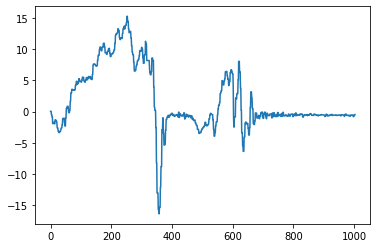

In [56]:
plt.plot(Fxs)

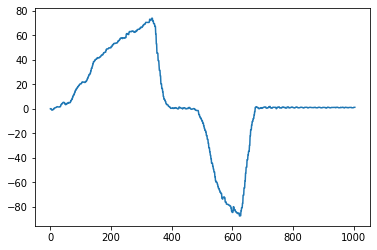

In [57]:
plt.plot(Fys)

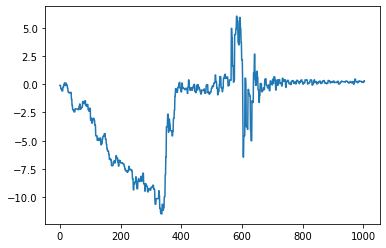

In [58]:
plt.plot(Fzs)

# Saving

In [31]:
save_dict = {
    "Pose" : {
        "trans_x" : trans_xs,
        "trans_y" : trans_ys,
        "trans_z" : trans_zs,
        "rot_x" : rot_xs,
        "rot_y" : rot_ys,
        "rot_z" : rot_zs,
    },
    "Force" : {
        "Fx"  : Fxs,
        "Fy"  : Fzs,
        "Fz"  : Fys,
    },
    "Torque" : {
        "Mx"  : Mxs,
        "My"  : Mys,
        "Mz"  : Mzs,
    },
    "Reward" : rewards,
    "Success" : success,
    "Episode_Length" : step,
}


filename = "{}".format(take).zfill(4)+"_{}.json".format(AGENT)
with open(os.path.join(*[SAVE_PATH, filename]), 'w') as file:
    json.dump(save_dict, file)
    file.close()

# Test Plots

In [28]:
poses_df = pandas.DataFrame(poses_rec, columns=["vz","lr","hr"])
ft_values_df = pandas.DataFrame(ft_values_rec, columns=["Fx", "Fy", "Fz", "Mx", "My", "Mz"])

NameError: name 'poses_rec' is not defined

<AxesSubplot:>

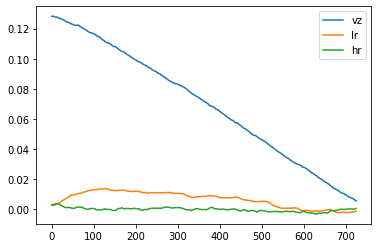

In [34]:
poses_df.plot()

<AxesSubplot:>

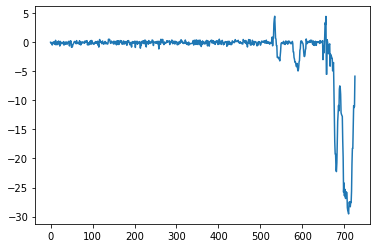

In [37]:
ft_values_df["Fx"].plot()

# !!! Save recorded Data !!!